In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import torch.nn.functional as F
import numpy as np
from utils import *

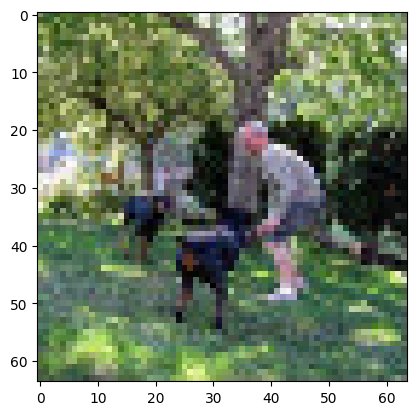

In [5]:
import cv2
import matplotlib.pyplot as plt
im = cv2.imread("testdata/Val_SR/lq/ILSVRC2012_val_00000134.png")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
# im = cv2.resize(im, dsize=(256,256))
plt.imshow(im)

In [6]:
lq = ((torch.tensor(im).permute(2, 0, 1)[None] / 255.) - 0.5) / 0.5
lq_up = F.interpolate(lq, scale_factor=4., mode='bicubic')

In [7]:
import yaml

with open("autoencoder.yaml") as file:
    config = yaml.safe_load(file)

In [8]:
ae_config = config["autoencoder"]
ae = instantiate_from_config(ae_config)
ae = prepare_model(ae, ae_config).cuda()

No module 'xformers'. Proceeding without it.
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.


In [9]:
lt = ae.encode(lq_up.cuda())

In [10]:
rec = ae.decode(lt)

/home/d-shlenskii/miniconda3/envs/default/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
def plot_tensor(out):
    out = (out[0].permute(1, 2, 0).detach().cpu().numpy() + 1.) * 0.5
    plt.imshow(out)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


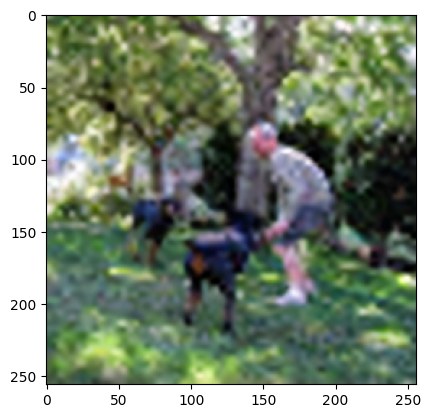

In [12]:
plot_tensor(rec)

In [13]:
model_config = config["model"]
model = instantiate_from_config(model_config)
model = prepare_model(model, model_config)
model.cuda()

/home/d-shlenskii/miniconda3/envs/default/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


UNetModelSwin(
  (time_embed): Sequential(
    (0): Linear(in_features=160, out_features=640, bias=True)
    (1): SiLU()
    (2): Linear(in_features=640, out_features=640, bias=True)
  )
  (feature_extractor): Identity()
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(6, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 160, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=640, out_features=320, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 160, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2

In [14]:
def add_noise(x, eta_end=0.98, kappa=2.0):
    print(kappa * eta_end**0.5)
    return x + torch.randn_like(x) * kappa * eta_end**0.5

In [15]:
def q_sample(x, y, eta, kappa=2.0):
    return x + eta * (y - x) + \
        eta**0.5 * kappa * torch.randn_like(x) * kappa * eta**0.5

In [16]:
# lt_noised = q_sample(lt, lt, 0.159395)
lt_noised = add_noise(lt)

1.9798989873223332


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


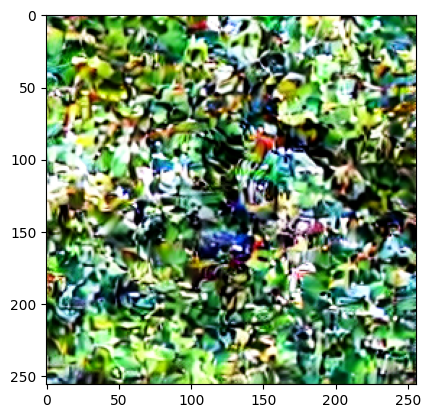

In [17]:
plot_tensor(ae.decode(lt_noised.cuda()))

In [18]:
lt_noised.min(), lt_noised.max()

(tensor(-10.2192, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(8.5923, device='cuda:0', grad_fn=<MaxBackward1>))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


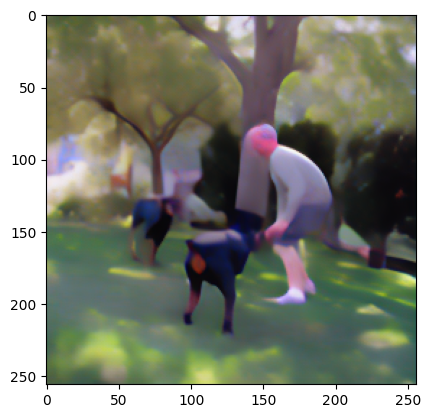

In [27]:
timesteps = torch.tensor([14])
std = (0.98 * 4. + 1)**0.5
sr = model(lt_noised.cuda() / std, timesteps.cuda(), lq.cuda())
with torch.no_grad():
    out = ae.decode(sr)
plot_tensor(out)

In [37]:
import numpy as np
a=1.9248
T=15
alpha_T= 2.1112561
lamb=np.log(1+alpha_T/a)

def alpha_fn(t, a=a, alpha_T=alpha_T, T=T): 
  lamb=np.log(1+alpha_T/a) 
  return a*(np.exp(lamb*t)-1) 
def eta_fn(t, a=a, alpha_T=alpha_T, T=T): 
  lamb=np.log(1+alpha_T/a) 
  return a*((np.exp(lamb*t)-1)/lamb-t)

class Solver:
  def __init__(
    self,
    x0_pred_fn,
    a=0.0741,
    alpha_T_prime=0.15451717,
    T=15,
    kappa=2.0, 
    device="cpu"
  ):
    self.alpha_fn = lambda t: alpha_fn(t, a, alpha_T_prime, T)
    self.eta_fn = lambda t: eta_fn(t, a, alpha_T_prime, T)
    self.T = T
    self.kappa = kappa
    self.x0_pred_fn = x0_pred_fn.to(device)
    self.device = device

    self.f = lambda alpha, e0, score:\
              alpha * e0 - 0.5 * alpha * self.kappa**2 * score

  def _get_score_with_x0(self, x, step_idx, x0, y0):
    eta = self._etas[step_idx]
    alpha = self._alphas[step_idx]
    return -(x - x0 * (1 - eta) - eta * y0) / (self.kappa**2 * alpha)

  def ode_step(self, x, step_idx, y0, lq):
    curr_timestep = torch.tensor([self._timesteps[step_idx]] * len(x), dtype=x.dtype, device=x.device)
    alpha = self._alphas[step_idx]

    std = (self.kappa**2 * self._etas[step_idx] + 1)**0.5
    x0 = self.x0_pred_fn(x / std, curr_timestep * self.T - 1, lq)
    e0 = y0 - x0
    score = self._get_score_with_x0(x, step_idx, x0, y0)

    h = self._timesteps[step_idx + 1] - self._timesteps[step_idx]
    x_next= x + h * self.T * self.f(alpha, e0, score)
    return x_next

  def __call__(self, timesteps, y0, y0_noised, lq):
    self._timesteps = timesteps.to(self.device)
    # self._alphas = self.alpha_fn(timesteps).to(self.device)
    # self._etas = self.eta_fn(timesteps).to(self.device) * self.T
    # print(self._alphas)
    # print(self._etas)
    self._alphas = torch.tensor([0, 0.0004,     0.01332702, 0.0173545,  0.02349744, 0.03043055, 0.03818878,
 0.04682581, 0.05639768, 0.06696108, 0.07857391, 0.09129569, 0.10518715,
 0.12031144, 0.13673162, 0.15451717,][::-1], device=self.device)
    self._etas = torch.tensor([0 ,3.99999990e-04, 1.37270205e-02, 3.10815237e-02, 5.45789599e-02,
 8.50095078e-02, 1.23198286e-01, 1.70024097e-01, 2.26421773e-01,
 2.93382853e-01, 3.71956766e-01, 4.63252455e-01, 5.68439603e-01,
 6.88751042e-01, 8.25482666e-01, 9.79999840e-01,][::-1], device=self.device)
    print(self._alphas)
    print(self._etas)
    y0 = y0.to(self.device)
    lq = lq.to(self.device)
    # print(timesteps * self.T)
    
    x = y0_noised.to(self.device)
    for i in range(len(timesteps) - 1):
      x = self.ode_step(x, i, y0, lq)
    return x

In [38]:
sv = Solver(model, device="cuda")

tensor([0.1545, 0.1367, 0.1203, 0.1052, 0.0913, 0.0786, 0.0670, 0.0564, 0.0468,
        0.0382, 0.0304, 0.0235, 0.0174, 0.0133, 0.0004, 0.0000],
       device='cuda:0')
tensor([9.8000e-01, 8.2548e-01, 6.8875e-01, 5.6844e-01, 4.6325e-01, 3.7196e-01,
        2.9338e-01, 2.2642e-01, 1.7002e-01, 1.2320e-01, 8.5010e-02, 5.4579e-02,
        3.1082e-02, 1.3727e-02, 4.0000e-04, 0.0000e+00], device='cuda:0')


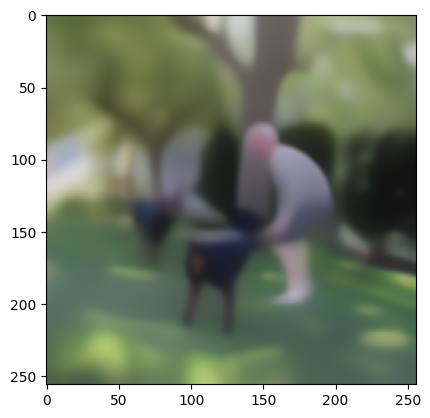

In [39]:
timesteps = torch.tensor(list(np.linspace(0, 1, 16))[::-1])
out = sv(timesteps, lt, lt_noised, lq)
plot_tensor(ae.decode(out).clip(-1, 1))